In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import helper
import requests
from heapq import nlargest
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
%matplotlib inline

In [2]:
#import User data and location data
def importData():
    #userIDSet=["0131412","0131412","2142144","0131412","0131412","0131412","1243551","3524541","2142144","1232144",
    #           "1232144","1232144","3524541","1243551","1243551","1243551","1232144","3524541","3524541","1232144",
    #           "3524541","2142144","2142144","0131412","2142144","2142144","2142144","2142144","0131412","2142144"]
    #latSet=[22.369453,22.364373,22.356991,22.372627,22.344501,22.351804,22.381649,22.366568,22.353709,22.379903,
    #        22.309567,22.313696,22.326400,22.323700,22.333545,22.313696,22.331163,22.347200,22.339261,22.327988,
    #        22.257332,22.250818,22.254949,22.277348,22.260192,22.288308,22.276395,22.306256,22.227302,22.238107,]
    #lngSet=[114.120113,114.122516,114.119254,114.108440,114.130891,114.096902,114.099477,114.150975,114.150117,114.109776,
    #        114.175008,114.165223,114.161618,114.188054,114.171574,114.179127,114.202645,114.182732,114.163678,114.195779,
    #        113.880496,113.922210,113.960834,113.915000,113.894572,113.981090,114.011646,113.918605,113.997741,113.926330]

    url = 'http://13.70.2.33/api/sql_db'
    myobj = {"db_name": "Smart Scheduler","sql_cmd": "SELECT * FROM user_location_history"}
    data = requests.post(url, data = myobj)
    dataJson=data.json()
    result=dataJson['result']
    userIDSet=[]
    latSet=[]
    lngSet=[]
    for i in range(len(result)):
        currentRecord=result[i]
        userIDSet.append(currentRecord['userId'])
        latSet.append(currentRecord['lat'])
        lngSet.append(currentRecord['lng'])
    print("userIDSet:")
    print(userIDSet)
    print("latSet:")
    print(latSet)
    print("lngSet:")
    print(lngSet)
    
    latlngData = np.column_stack([np.array(latSet), np.array(lngSet)])
    visualizeRawData(latlngData)
    
    return userIDSet,latSet,lngSet,latlngData

#visualize the data
def visualizeRawData(latlngData):
    fig, ax = plt.subplots()
    ax.plot(latlngData[:, 0], latlngData[:, 1], 'o', markersize=2, c='darkblue');

In [3]:
#try different numbers of cluster
def findBestnumbersOfcluster(latlngData):
    test_n_cluster = 20
    within_cluster_sum_squares = np.zeros(test_n_cluster)
    for i in range(test_n_cluster):
        n = i+1
        kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter=500, n_init=20, random_state = 0)
        kmeans.fit(latlngData)
        within_cluster_sum_squares[i] = kmeans.inertia_
    showTrendOfResult(within_cluster_sum_squares)
    visualizeTrend(within_cluster_sum_squares,test_n_cluster)
    
    return test_n_cluster

#show the trend of changing number of cluster    
def showTrendOfResult(within_cluster_sum_squares):
    np.set_printoptions(suppress=True)
    np.around(within_cluster_sum_squares, 2)

#visualize the trend   
def visualizeTrend(within_cluster_sum_squares,test_n_cluster):
    fig, ax = plt.subplots()
    ax.plot(within_cluster_sum_squares)
    xticks = np.arange(test_n_cluster)
    xticklabels = xticks + 1
    ax.set(xticks=xticks, xticklabels=xticklabels, title='The Elbow Method', 
        xlabel='Number of clusters, Picture 0', ylabel='WCSS');

In [4]:
#get the proper number of cluster
def ElbowMethod(latlngData, top_cluster_number, remark=True, init = 'k-means++', max_iter = 300, n_init = 10, random_state = None):
    #import numpy as np
    #from sklearn.cluster import KMeans
    wcss = np.zeros(top_cluster_number)
    
    for i in range(top_cluster_number):
        n = i+1
        kmeans = KMeans(n_clusters = n, init=init, max_iter=max_iter, n_init=n_init, random_state=random_state)
        kmeans.fit(latlngData)
        wcss[i] = kmeans.inertia_
    
    cosines = -1 * np.ones(top_cluster_number)
    
    for i in range(top_cluster_number-1):
    # check if the point is below a segment midpoint connecting its neighbors
        if (wcss[i] < (wcss[i+1]+wcss[i-1])/2 ):
            cosines[i]= (-1+(wcss[i-1]-wcss[i])*(wcss[i+1]-wcss[i]))/ \
            ((1+(wcss[i-1]-wcss[i])**2)*(1+ (wcss[i+1]-wcss[i])**2))**.5
    
    if remark:
        print("""Remark: If repeated applications(with different random_state parameters) yield different 
        values for the optimal number then K-means method does not work well on the array.""")
    
    return (np.flip(np.argsort(cosines))+1)

In [5]:
#convert userIDSet to numIdx
def userIDSetToNumIdx(userIDSet,latSet,lngSet):
    userIDBook=[]
    userIDIdxSet=[]
    for i in range(len(userIDSet)):
        if userIDSet[i] not in userIDBook:
            userIDBook.append(userIDSet[i])
        userIDIdxSet.append(userIDBook.index(userIDSet[i]))
    #print("userIDBook:")
    #print(userIDBook)
    #print("userIDSet:")
    #print(userIDSet)
    #print("userIDIdxSet:")
    #print(userIDIdxSet)


    #form the dataset for clustering
    numOfUser=len(userIDBook)
    userIDIdx = pd.Series(userIDIdxSet)
    lat = pd.Series(latSet)
    lng = pd.Series(lngSet)
    d = {'UserID_index':userIDIdx, 'Lat': lat, 'Lng': lng}
    dataset = pd.DataFrame(d)
    #print(dataset)
    
    return userIDBook,numOfUser,userIDIdx,lat,lng,d,dataset

In [6]:
#clustering using helper.py
def clustering(lat,lng,dataset):
    minLat=lat.min()
    maxLat=lat.max()
    minLng=lng.min()
    maxLng=lng.max()
    #print(minLat)
    #print(maxLat)
    #print(minLng)
    #print(maxLng)
    latRange=maxLat-minLat
    lngRange=maxLng-minLng
    lowerLat=minLat-latRange/2
    upperLat=maxLat+latRange/2
    lowerLng=minLng-lngRange/2
    upperLng=maxLng+lngRange/2
    helper.draw_scatterplot(dataset['Lat'],'Lat', dataset['Lng'], 'Lng', lowerLat, upperLat, lowerLng, upperLng)
    
    return lowerLat, upperLat, lowerLng, upperLng

In [7]:
#convert proper data type for clustering
def convertProperDataType(dataset,suggestedNumOfCluster,lowerLat, upperLat, lowerLng, upperLng):
    X = dataset[['Lat','Lng']].values
    #print("dataset(type:"+str(type(X))+")")
    #print(X)

    #Create an instance of KMeans
    numOfClusters=suggestedNumOfCluster[0]
    kmeans_1 = KMeans(n_clusters=numOfClusters, random_state=0)
    #Use fit_predict to cluster the dataset
    predictions = kmeans_1.fit_predict(X)

    #check data value
    print("X(type:"+str(type(X))+")")
    print(X)
    print("predictions(type:"+str(type(predictions))+")")
    print(predictions)
    
    visualizeClusteringResult(dataset,predictions,lowerLat, upperLat, lowerLng, upperLng)
    
    return predictions,numOfClusters
    
#visualize the result of clustering
def visualizeClusteringResult(dataset,predictions,lowerLat, upperLat, lowerLng, upperLng):
    helper.draw_clusters(dataset, predictions, 'Lat', 'Lng', lowerLat, upperLat, lowerLng, upperLng)

In [8]:
#count # of users appear in each cluster
def getClusteringResult(userIDIdx,numOfClusters,predictions):
    clusters=[]
    userIDArray = userIDIdx.to_numpy()
    for i in range(numOfClusters):
        clusters.append([])
    for i in range(len(predictions)):
        clusters[predictions[i]].append(userIDArray[i])
    print(clusters)
    
    return clusters

In [9]:
#get user avg occurence for calculation
def getUserAvgOccurence(numOfUser,numOfClusters,clusters):
    userAvgOccurrence=[]
    for i in range(numOfUser):
        currentUserOccurence=0
        for j in range(numOfClusters):
            currentUserOccurence+=clusters[j].count(i+1)
        userAvgOccurrence.append(currentUserOccurence/numOfClusters)
    #print("userAvgOccurrence:")
    #print(userAvgOccurrence)
    
    return userAvgOccurrence


#functions
def covOfUserAB(A,B,clusters,userAvgOccurrence,numOfClusters):
    sONOOUAB=0 #sONOOUAB: sum of normalized occurrence of user A,B
    for i in range(numOfClusters):
        sONOOUAB+=(clusters[i].count(A)-userAvgOccurrence[A-1])*(clusters[i].count(B)-userAvgOccurrence[B-1])
    sONOOUAB=sONOOUAB/numOfClusters
    #print("soNOOUAB:")
    #print(sONOOUAB)
    return sONOOUAB

def stdDevOfUser(A,clusters,userAvgOccurrence,numOfClusters):
    numerator=0
    for i in range(numOfClusters):
        numerator+=(clusters[i].count(A)-userAvgOccurrence[A-1])**2
    result=pow(numerator/numOfClusters,0.5)
    #print("result:")
    #print(result)
    return result

def simOfUserAB(A,B,clusters,userAvgOccurrence,numOfClusters):
    numerator=covOfUserAB(A,B,clusters,userAvgOccurrence,numOfClusters)
    denominator=(stdDevOfUser(A,clusters,userAvgOccurrence,numOfClusters)*stdDevOfUser(B,clusters,userAvgOccurrence,numOfClusters))
    if(denominator==0): #means all data of A and B are the same
        result=-1.0
    else:
        result=numerator/denominator
    #print("numerator:")
    #print(numerator)
    #print("denominator:")
    #print(denominator)
    #print("numerator/denominator:")
    #print(result)
    #print("------------------------")
    return result #result 1:similar, 0:no linear relationship, -1:opposite

#to find the distance matrix of all user
def getUserDistanceMatrix(numOfUser,clusters,userAvgOccurrence,numOfClusters):
    userDistanceMatrix=[]
    for i in range(numOfUser):
        userDistanceMatrix.append([])
        for j in range(numOfUser):
            if(i>j):
                userDistanceMatrix[i].append(userDistanceMatrix[j][i])
            if(i==j):
                userDistanceMatrix[i].append(-1.0)
            if(i<j):
                userDistanceMatrix[i].append(simOfUserAB(i,j,clusters,userAvgOccurrence,numOfClusters))
    print("userDistanceMatrix:")
    print(userDistanceMatrix)
    return userDistanceMatrix

In [10]:
#get Nth similar Users
def getNthUserMostSimilarTotarget(userID,Nth):
    #get required data
    userIDSet,latSet,lngSet,latlngData=importData()
    test_n_cluster=findBestnumbersOfcluster(latlngData)
    suggestedNumOfCluster=ElbowMethod(latlngData, 20, max_iter=500, n_init=20)
    userIDBook,numOfUser,userIDIdx,lat,lng,d,dataset=userIDSetToNumIdx(userIDSet,latSet,lngSet)
    lowerLat, upperLat, lowerLng, upperLng=clustering(lat,lng,dataset)
    predictions,numOfClusters=convertProperDataType(dataset,suggestedNumOfCluster,lowerLat, upperLat, lowerLng, upperLng)
    clusters=getClusteringResult(userIDIdx,numOfClusters,predictions)
    
    #start calculate
    userAvgOccurrence=getUserAvgOccurence(numOfUser,numOfClusters,clusters)
    if userID in userIDBook:
        targetUserIdx=userIDBook.index(userID)
        print("targetUserIdx:")
        print(targetUserIdx)
        #idxOfUserID=allUserID.copy()
        similaritiesOfUserA=getUserDistanceMatrix(numOfUser,clusters,userAvgOccurrence,numOfClusters)[targetUserIdx].copy() #result 1:similar, 0:no linear relationship, -1:opposite
        idxForSimilaritiesOfUserA=[]
        for i in range(len(similaritiesOfUserA)):
            idxForSimilaritiesOfUserA.append(i)
        #print("idxOfUserID:")
        #print(idxOfUserID)
        print("similaritiesOfUserA:")
        print(similaritiesOfUserA)
        print("idxForSimilaritiesOfUserA:")
        print(idxForSimilaritiesOfUserA)
        result=nlargest(Nth, idxForSimilaritiesOfUserA, key=lambda i: similaritiesOfUserA[i])
        print("result:")
        print(result)

        #filter out -1 to 0 results
        #result 1:similar, 0:no linear relationship, -1:opposite
        result = [item for item in result if similaritiesOfUserA[item]>0.0]
        print("filtered result:")
        print(result)

        #get back the user ID of the result
        NthUser=[]
        for i in range(len(result)):
            #NthUser.append(idxOfUserID[result[i]])
            NthUser.append(userIDBook[result[i]])
        print("result(in user ID):")
        print(NthUser)

        return NthUser
    else:
        return []


userIDSet:
[1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 20, 20, 20, 20, 20, 20, 20, 20]
latSet:
[22.3195854, 22.3249424, 22.326919, -35.27801, -35.28032, -35.28099, 22.321305, 22.321077, 22.320839, 22.32077, -35.28144, -35.28194, -35.28282, -35.28302, -35.28473, 22.330558, 22.3329, 22.332771, 22.329466, 22.327759, 22.327005, 22.324712, 22.322519, 22.318738, 22.317487, 0.0, 22.3319409, 22.3381934, 22.3319409, 22.31290054321289, 22.31290054321289, 22.31290054321289, 22.31290054321289, 22.31290054321289]
lngSet:
[114.168322, 114.1667213, 114.1647144, 149.12958, 149.12907, 149.12929, 114.1627, 114.164438, 114.166777, 114.168762, 149.12984, 149.13003, 149.12956, 149.12881, 149.12836, 114.165767, 114.169082, 114.175412, 114.18701, 114.184049, 114.178116, 114.172494, 114.168535, 114.165821, 114.160918, 0.0, 114.1641195, 114.1566356, 114.1641195, 114.17056274414062, 114.17056274414062, 114.17056274414062, 114.17056274414062, 114.17056274414062]
Remark: If re

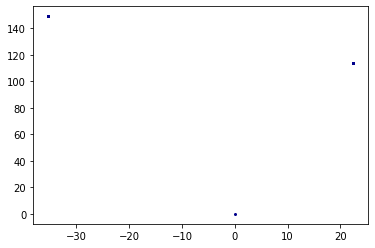

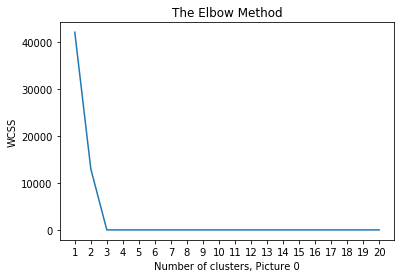

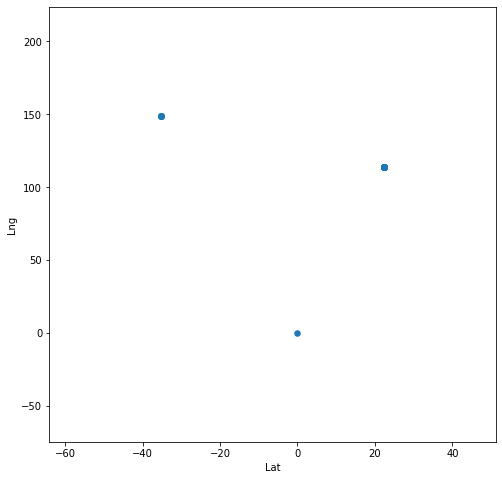

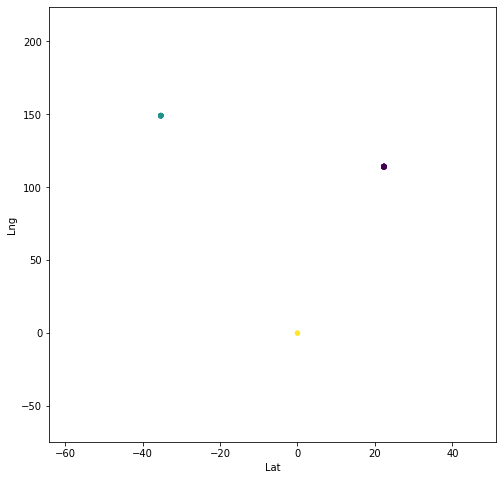

In [14]:
#to get n similar Users
#QUERY HERE ~ 2 parameters: targetUser & numOfResult
targetUser=1
numOfResult=2 #Note: if numOfResult > possible results, # of output will < numOfResult
userIdResult=getNthUserMostSimilarTotarget(targetUser,numOfResult)

In [12]:
print("Result User ID:")
print("(Note: if numOfResult > possible results, # of output will < numOfResult)")
print(userIdResult)
print("have similar behavior to targetUser")

Result User ID:
(Note: if numOfResult > possible results, # of output will < numOfResult)
[20]
have similar behavior to targetUser


In [13]:
#Backup testing data
#cluster 1:
#22.369453, 114.120113
#22.364373, 114.122516
#22.356991, 114.119254
#22.372627, 114.108440
#22.344501, 114.130891
#22.351804, 114.096902
#22.381649, 114.099477
#22.366568, 114.150975
#22.353709, 114.150117
#22.379903, 114.109776


#cluster 2:
#22.309567, 114.175008
#22.313696, 114.165223
#22.326400, 114.161618
#22.323700, 114.188054
#22.333545, 114.171574
#22.313696, 114.179127
#22.331163, 114.202645
#22.347200, 114.182732
#22.339261, 114.163678
#22.327988, 114.195779


#cluster 3:
#22.257332, 113.880496
#22.250818, 113.922210
#22.254949，113.960834
#22.277348, 113.915000
#22.260192, 113.894572
#22.288308, 113.981090
#22.276395, 114.011646
#22.306256, 113.918605
#22.227302, 113.997741
#22.238107，113.926330

#userID
#0: 0131412
#1: 2142144
#2: 1243551
#3: 3524541
#4: 1232144
#["0131412","0131412","2142144","0131412","0131412","0131412","1243551","3524541","2142144","1232144",
# "1232144","1232144","3524541","1243551","1243551","1243551","1232144","3524541","3524541","1232144",
# "3524541","2142144","2142144","0131412","2142144","2142144","2142144","2142144","0131412","2142144"]


In [14]:
#Backup code

[-0.06557089  0.01156865  0.018254    0.01432585  0.0128582  -0.07675992
  0.01665919  0.01433408 -0.0948983   0.06731068]
[-0.00186546 -0.1375271   0.10906031 -0.0312116   0.00171566 -0.15834485
  0.13499329  0.22756762 -0.12301687 -0.08182307]
[0.92096016 0.94798693 0.9722562  0.97949324 1.08282301 1.19662357
 1.01620721 0.96410388 1.12581785 0.84859626]
[1.1068359  0.96299819 1.21475458 0.82958598 1.09858571 1.09351093
 1.02618495 0.8418057  1.12973505 0.81410357]
[1.86770114 2.24736651 2.0962122  2.05430756 2.02682818 2.00987317
 2.00803516 1.84303392 2.14222331 1.89186828]
[2.04640162 2.03977931 1.78212602 2.10912702 2.08000206 1.98300887
 2.04217319 1.965095   2.02058972 1.8438109 ]


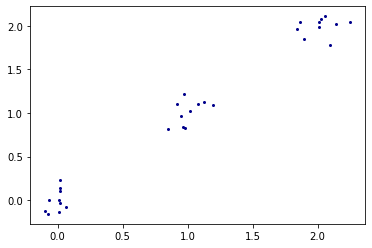

In [15]:
#Reference Sample
# number of clusters: real and assumed for testing.
true_n_cluster = 3

n_obs = 10

X = None

for i in range(true_n_cluster):
    x = np.random.normal(loc=i, size=n_obs, scale=0.1)#generate data
    y = np.random.normal(loc=i, size=n_obs, scale=0.1)#generate data
    print(x)
    print(y)
    data = np.column_stack([x, y])
    #print(data)
    if X is None:
        X = data
    else:
        X = np.row_stack([X, data])
        
#print(X)

fig, ax = plt.subplots()

ax.plot(X[:, 0], X[:, 1], 'o', markersize=2, c='darkblue');